# Classifier deux couches

In [46]:
import pandas as pd
import numpy as np
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


In [47]:
print('Extraction des données ...')
labels = []
text = []
with open('../data/spam.csv','r') as f :
    lines = f.readlines()
    print(lines[1])
    for i in lines[1:] :
        label = i.split(",")[0]
        labels.append(1 if label == "spam" else 0)
        if i.split(',')[1].startswith('"'):  # Dans le csv, il y a des données entre "" qui ont ensuite le separateur virgule. On ne parse pas de la même façon dans ce cas.
            text.append(i.split('"')[1])
        else :
            text.append(i.split(',')[1])

print(f"Nombre de label : {len(labels)}")
print(f"Nombre de text : {len(text)}")



Extraction des données ...
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,

Nombre de label : 5574
Nombre de text : 5574


In [48]:
print("Tokenisation du texte : ")
tokenizer = tiktoken.get_encoding("cl100k_base")
train_tokens = [tokenizer.encode(text) for text in text]
print(f"Nombre de mot de vocabulaire : {tokenizer.n_vocab}")


Tokenisation du texte : 
Nombre de mot de vocabulaire : 100277


In [49]:
print("On détermine la longueur moyenne d'une séquence : ")
seq_lens = [len(seq) for seq in train_tokens]
print(f"Moyenne : {np.mean(seq_lens)}")
print(f"Max : {np.max(seq_lens)}")

On détermine la longueur moyenne d'une séquence : 
Moyenne : 22.21707929673484
Max : 259


In [50]:
def pad_sequences(sequences, max_length=25):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens_seq = pad_sequences(train_tokens)
print(len(train_tokens_seq))
print(train_tokens_seq[:1])

5574
[[11087, 3156, 16422, 647, 1486, 11, 14599, 497, 16528, 1193, 304, 10077, 285, 308, 2294, 1917, 1208, 384, 61886, 1131, 356, 483, 1070, 2751, 72375]]


In [51]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    
df_dataset = IMDBDataset(train_tokens_seq, labels)

print(df_dataset.texts[:5])

train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

tensor([[11087,  3156, 16422,   647,  1486,    11, 14599,   497, 16528,  1193,
           304, 10077,   285,   308,  2294,  1917,  1208,   384, 61886,  1131,
           356,   483,  1070,  2751, 72375],
        [11839, 45555,  1131,   622, 10979,   289,   333,   577,   389,    72,
          1131,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [11180,  4441,   304,   220,    17,   264, 74860,   398,  1391,   311,
          3243, 15358, 11098,  1620, 17603,  2641,   220,  1691,   267,  3297,
           220,  1049,    20,    13,  2991],
        [   52, 50116,  2019,   779,  4216,  4917,  1131,   549,   272,  2736,
          1243,  2019,  1131,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [   45,  1494,   358,  1541,   956,  1781,   568,  5900,   311,   603,
            69,    11,   568,  6439,  2212,  1618,  3582,     0,     0,     0,
             0,     0,     0, 

In [52]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [53]:
vocab_size = tokenizer.n_vocab
sample_input = torch.tensor([[1, 2, 3]])

In [54]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim,couche_inter,num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embed_dim, couche_inter)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(couche_inter,num_class)
        self.drop_out = nn.Dropout(p=0.2)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.drop_out(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=64,
                      couche_inter=32,
                      num_class=1)

In [55]:
from torchinfo import summary
print(model)

# Print model summary
summary(model, input_data=sample_input)  # (batch_size, input_features)

TextClassifier(
  (embedding): Embedding(100277, 64, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [1, 1]                    --
├─Embedding: 1-1                         [1, 3, 64]                6,417,728
├─AdaptiveAvgPool1d: 1-2                 [1, 64, 1]                --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Dropout: 1-5                           [1, 32]                   --
├─Linear: 1-6                            [1, 1]                    33
Total params: 6,419,841
Trainable params: 6,419,841
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 25.68
Estimated Total Size (MB): 25.68

In [56]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    #From Jedha course
    """
    Function to train a PyTorch model with training and validation datasets.
    
    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).
    
    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """
    
    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate batch loss
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions  seuil de 0.5
        
        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history  # Return training history

history_after = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=10)


Epoch [1/10], Loss: 0.4893, Acc: 0.8666, Val Loss: 0.3205, Val Acc: 0.8646
Epoch [2/10], Loss: 0.2324, Acc: 0.9226, Val Loss: 0.1654, Val Acc: 0.9596
Epoch [3/10], Loss: 0.1308, Acc: 0.9648, Val Loss: 0.1126, Val Acc: 0.9686
Epoch [4/10], Loss: 0.0840, Acc: 0.9773, Val Loss: 0.0906, Val Acc: 0.9758
Epoch [5/10], Loss: 0.0592, Acc: 0.9834, Val Loss: 0.0781, Val Acc: 0.9758
Epoch [6/10], Loss: 0.0397, Acc: 0.9892, Val Loss: 0.0716, Val Acc: 0.9785
Epoch [7/10], Loss: 0.0267, Acc: 0.9926, Val Loss: 0.0677, Val Acc: 0.9794
Epoch [8/10], Loss: 0.0213, Acc: 0.9964, Val Loss: 0.0660, Val Acc: 0.9812
Epoch [9/10], Loss: 0.0137, Acc: 0.9978, Val Loss: 0.0658, Val Acc: 0.9821
Epoch [10/10], Loss: 0.0099, Acc: 0.9991, Val Loss: 0.0669, Val Acc: 0.9830


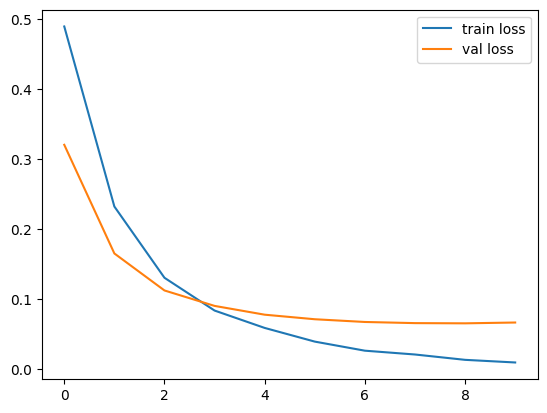

In [57]:
import matplotlib.pyplot as plt
plt.plot(history_after['loss'], label="train loss")
plt.plot(history_after['val_loss'], label="val loss")
plt.legend()
plt.show()